In [1]:
import scanpy as sc
import os

In [2]:
base_dir = '../Data/Huang_Yuhsin_Vivian_et_al/Unzip'
sample_dirs = os.listdir(base_dir)

In [13]:
adatas = []
for sample in sample_dirs:
    # 构建完整路径
    sample_path = os.path.join(base_dir, sample)
    # 读取10x数据，处理基因名重复
    adata = sc.read_10x_mtx(
        sample_path,
        var_names='gene_symbols',  # 使用基因符号作为变量名
        make_unique=True  # 自动处理重复基因名
    )
    adatas.append(adata)
combined_adata = sc.concat(
    adatas,
    axis=0,  # 合并方向（细胞方向）
    keys=sample_dirs,  # 样本标识符
    label='sample',  # 在obs中记录样本来源的列名
    join='outer'  # 合并方式（保留所有基因）
)
combined_adata.obs_names = [f"{sample}_{cell}" for sample, cell in
                            zip(combined_adata.obs["sample"], combined_adata.obs_names)]
combined_adata.var_names_make_unique()
combined_adata.obs_names_make_unique()
# 查看合并后的数据集信息
print(combined_adata)

AnnData object with n_obs × n_vars = 258813 × 33502
    obs: 'sample'


C:\Environment\anaconda3\envs\singlecell\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [14]:
sc.pp.filter_cells(combined_adata, min_genes=200)
sc.pp.filter_genes(combined_adata, min_cells=3)
print(combined_adata.obs)
sc.pp.scrublet(combined_adata, batch_key="sample")

In [18]:
combined_adata.var["mt"] = combined_adata.var_names.str.startswith("mt-")
combined_adata.var["ribo"] = combined_adata.var_names.str.contains("^Mrp[ls]")
combined_adata.var["hb"] = combined_adata.var_names.str.contains("^Hb[^(P)]")
sc.pp.calculate_qc_metrics(
    combined_adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)
combined_adata_bak = combined_adata


C:\Users\yuanf\AppData\Local\Temp\ipykernel_31480\2318686468.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  combined_adata.var["mt"] = combined_adata.var_names.str.startswith("mt-")


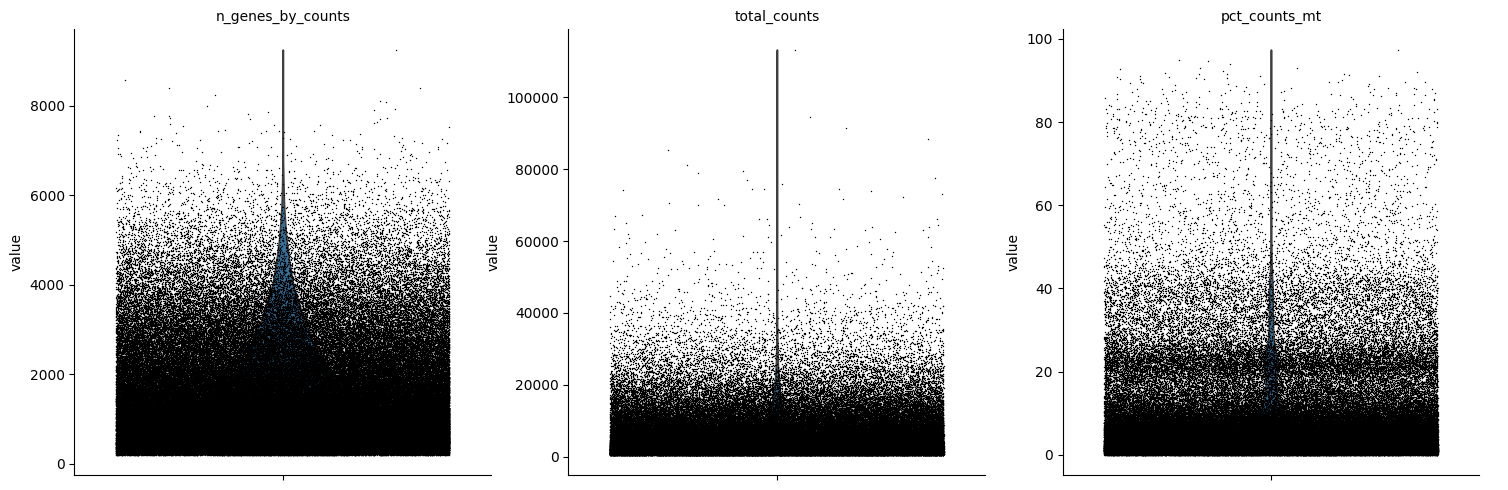

In [19]:
sc.pl.violin(
    combined_adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

In [20]:
combined_adata = combined_adata[combined_adata.obs.predicted_doublet == False, :]
combined_adata = combined_adata[combined_adata.obs.doublet_score <= 0.25, :]
combined_adata

View of AnnData object with n_obs × n_vars = 236835 × 24180
    obs: 'sample', 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'scrublet'

In [21]:
combined_adata = combined_adata[combined_adata.obs.n_genes_by_counts < 5000, :]
combined_adata = combined_adata[combined_adata.obs.pct_counts_mt < 25, :]
combined_adata = combined_adata[combined_adata.obs.total_counts < 30000, :]
combined_adata = combined_adata[combined_adata.obs.total_counts > 500, :]
print(combined_adata)


View of AnnData object with n_obs × n_vars = 221673 × 24180
    obs: 'sample', 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'scrublet'


In [22]:
combined_adata.write_h5ad('../Data/Huang_Yuhsin_Vivian_et_al.h5ad')